In [62]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import *

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin

## Load data

In [2]:
PATH = os.getcwd()

In [3]:
raw_df = pd.read_csv(f'{PATH}/data/Airline-Sentiment-2-w-AA.csv', encoding='ISO-8859-1')

In [4]:
raw_df.shape

(14640, 20)

In [5]:
raw_df.sample(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
6909,681457405,False,finalized,3,2/25/15 6:51,negative,0.6617,Late Flight,0.6617,Delta,NaN,DatingRev,NaN,0,@JetBlue well our plane just landed at the int...,NaN,2/23/15 17:56,5.700400e+17,"Los Angeles, CA",Eastern Time (US & Canada)
10027,681461315,False,finalized,3,2/25/15 6:14,neutral,0.6424,NaN,0.0000,US Airways,NaN,Hawaii_brown,NaN,0,@USAirways flights to Dfw Cancelled Flightled ...,NaN,2/22/15 10:32,5.695650e+17,violet crown,Central Time (US & Canada)
10380,681461671,False,finalized,3,2/25/15 7:45,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,realmattberry,NaN,0,@USAirways on hold 3 hours !!!!!! What's the n...,NaN,2/21/15 19:46,5.693430e+17,NYC,Eastern Time (US & Canada)
9472,681460757,False,finalized,3,2/25/15 8:11,positive,1.0000,NaN,NaN,US Airways,NaN,FitzFrancis,NaN,0,@USAirways it was customer service like I have...,NaN,2/23/15 9:53,5.699180e+17,NaN,NaN
1103,681449864,False,finalized,3,2/25/15 3:14,positive,0.6349,NaN,0.0000,United,NaN,gwen1013,NaN,0,@united Great! I'm ready to go home.,NaN,2/23/15 10:30,5.699270e+17,"New Haven, CT",NaN


In [6]:
raw_df.isnull().sum()

_unit_id                            0
_golden                             0
_unit_state                         0
_trusted_judgments                  0
_last_judgment_at                  56
airline_sentiment                   0
airline_sentiment:confidence        0
negativereason                   5462
negativereason:confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_id                            0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [7]:
raw_df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [8]:
df = raw_df[['text', 'airline_sentiment']].copy()

In [9]:
df.shape

(14640, 2)

In [10]:
df.sample(5)

,text,airline_sentiment
98,@virginamerica What is your phone number. I ca...,negative
5542,@SouthwestAir I would sell my nonexistent soul...,neutral
13200,@AmericanAir received an email requesting I ca...,negative
13390,@AmericanAir BRING MY FIANCÌä @meerikangas BAC...,negative
6632,@SouthwestAir please send me a number to call ...,negative


## Preprocess data

Encode categorical label class into numerical

In [11]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['airline_sentiment'])

Text cleaning

In [63]:
ct = TextCleaner()
df['clean_text'] = ct.transform(df['text'])

Tokenizer

In [42]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
stemmer = snowballstemmer.EnglishStemmer()

def tokenize(s): 
    tokens = re_tok.sub(r' \1 ', s).split()
    return stemmer.stemWords(tokens)

Train, test splitting

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'].values, df['target'].values, test_size=0.25, random_state=0)

Td-idf

In [44]:
vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.75, min_df=3, sublinear_tf=True)

In [45]:
tfidf_train = vect.fit_transform(X_train)
tfidf_test = vect.transform(X_test)

## Naive Bayes

In [46]:
def naive_bayes(x, y):
    r = []; b = []
    labels = np.unique(y)

    for l in labels:
        other_l = labels[labels != l]
        p = x[y == l].sum(0) + 1
        q = x[(y == other_l[0]) | (y == other_l[1])].sum(0) + 1
        r.append(np.log((p/p.sum())/(q/q.sum())))
        b.append(np.log(len(p)/len(q)))
    
    return r, b

In [49]:
r, b = naive_bayes(tfidf_train, y_train)

pre_preds = []
for j in range(len(r)):
    pre_preds.append(np.asarray(tfidf_test @ r[j].T + b[j]).reshape(-1))
arr = np.array(pre_preds)

In [50]:
metrics.accuracy_score(y_test, np.argmax(arr.T, 1))

0.7959016393442623

In [51]:
print(metrics.classification_report(y_test, np.argmax(arr.T, 1), target_names=le.classes_))

             precision    recall  f1-score   support

   negative       0.82      0.94      0.87      2327
    neutral       0.72      0.49      0.59       772
   positive       0.77      0.63      0.69       561

avg / total       0.79      0.80      0.78      3660



## Logistic Regression

In [52]:
scores = cross_val_score(LogisticRegression(C=4, dual=True), tfidf_train, y_train, cv=5)

In [53]:
scores

array([0.80709736, 0.79745107, 0.80546697, 0.80091116, 0.81867882])

In [54]:
np.mean(scores), np.std(scores)

(0.8059210756972217, 0.007227586380912802)

In [55]:
m = LogisticRegression(C=4, dual=True)
m.fit(tfidf_train, y_train)
preds = m.predict(tfidf_test)

In [56]:
(preds==y_test).mean()

0.8087431693989071

In [57]:
print(metrics.classification_report(y_test, preds, target_names=le.classes_))

             precision    recall  f1-score   support

   negative       0.83      0.94      0.88      2327
    neutral       0.71      0.54      0.62       772
   positive       0.81      0.63      0.71       561

avg / total       0.80      0.81      0.80      3660



#### Tokens importance

In [58]:
def get_tokens_coefs(vocab, coefs, n):
    coef_df = pd.DataFrame({'vocab': vocab, 'coef':coefs.reshape(-1)})
    return coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:n]

In [59]:
def plot_tokens_coefs(df, ax, label):
    df.sort_values('coef').plot.barh(legend=False, ax=ax)
    ax.set_yticklabels(df['vocab'].values.tolist()[::-1])
    ax.set_title(label);

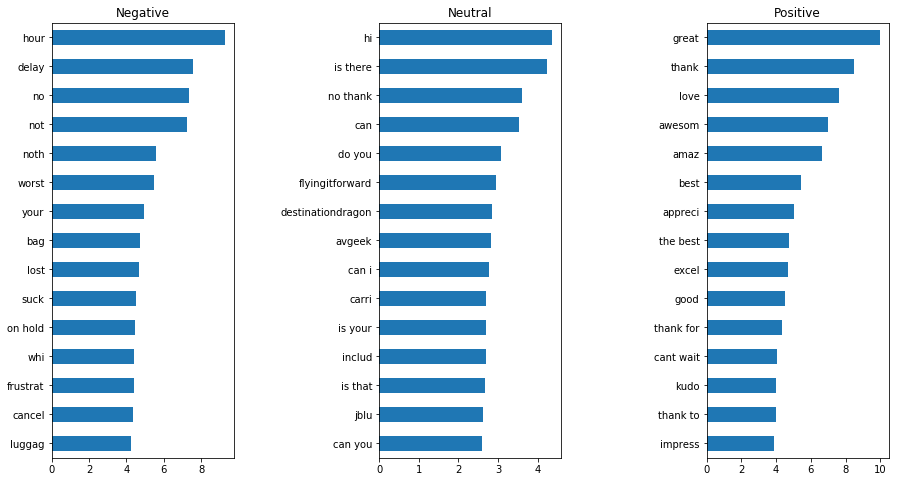

In [60]:
vocab = vect.get_feature_names()
n_coefs = 15

fig, axs = plt.subplots(1, 3, figsize=(15, 8))
fig.subplots_adjust(wspace=0.8)

for i, l in enumerate(['Negative', 'Neutral', 'Positive']):
    coef_df = get_tokens_coefs(vocab, m.coef_[i], n_coefs)
    plot_tokens_coefs(coef_df, axs[i], l)